In [3]:
import matplotlib.pyplot as plt
import pandas as pd 
import os
import pywt
import numpy as np

import csv
from scipy import stats
plt.rcParams["figure.figsize"] = (30,6)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True 


In [4]:
def denoise(data): 
    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    threshold = 0.04 # Threshold for filtering

    coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
        
    datarec = pywt.waverec(coeffs, 'sym4')
    
    return datarec
path = os.path.join(os.getcwd(),'mitbih_database')
window_size = 2000
maximum_counting = 10000

classes = ['N', 'L', 'R', 'A', 'V']
n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()
filenames = next(os.walk(path))[2]

# Split and save .csv , .txt 
records = list()
annotations = list()
filenames.sort()
for f in filenames:
    filename, file_extension = os.path.splitext(f)
    
    # *.csv
    if(file_extension == '.csv'):
        records.append(os.path.join(path, filename + file_extension))

    # *.txt
    else:
        annotations.append(os.path.join(path, filename + file_extension))
print(records)

['d:\\Projects\\verilogECG\\machineLearning\\mitbih_database\\100.csv', 'd:\\Projects\\verilogECG\\machineLearning\\mitbih_database\\101.csv', 'd:\\Projects\\verilogECG\\machineLearning\\mitbih_database\\102.csv', 'd:\\Projects\\verilogECG\\machineLearning\\mitbih_database\\103.csv', 'd:\\Projects\\verilogECG\\machineLearning\\mitbih_database\\104.csv', 'd:\\Projects\\verilogECG\\machineLearning\\mitbih_database\\105.csv', 'd:\\Projects\\verilogECG\\machineLearning\\mitbih_database\\106.csv', 'd:\\Projects\\verilogECG\\machineLearning\\mitbih_database\\107.csv', 'd:\\Projects\\verilogECG\\machineLearning\\mitbih_database\\108.csv', 'd:\\Projects\\verilogECG\\machineLearning\\mitbih_database\\109.csv', 'd:\\Projects\\verilogECG\\machineLearning\\mitbih_database\\111.csv', 'd:\\Projects\\verilogECG\\machineLearning\\mitbih_database\\112.csv', 'd:\\Projects\\verilogECG\\machineLearning\\mitbih_database\\113.csv', 'd:\\Projects\\verilogECG\\machineLearning\\mitbih_database\\114.csv', 'd:\\

In [5]:
# Records
for r in range(0, len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV file
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1

    signals = denoise(signals)    
    signals = stats.zscore(signals)
    

    example_beat_printed = False
    
    stride = 10
    
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines()
        beat = list()

        for d in range(1, len(data), stride):  # Step by stride
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted)  # Time... Clipping
            pos = int(next(splitted))  # Sample ID
            arrhythmia_type = next(splitted)  # Type
            
            if arrhythmia_type in classes:
                arrhythmia_index = classes.index(arrhythmia_type)
                count_classes[arrhythmia_index] += 1
                
                if window_size <= pos < (len(signals) - window_size):
                    beat = signals[pos - window_size : pos + window_size]

                    # Add to the dataset
                    X.append(beat)
                    y.append(arrhythmia_index)

# data shape
print(np.shape(X), np.shape(y))


(9964, 4000) (9964,)


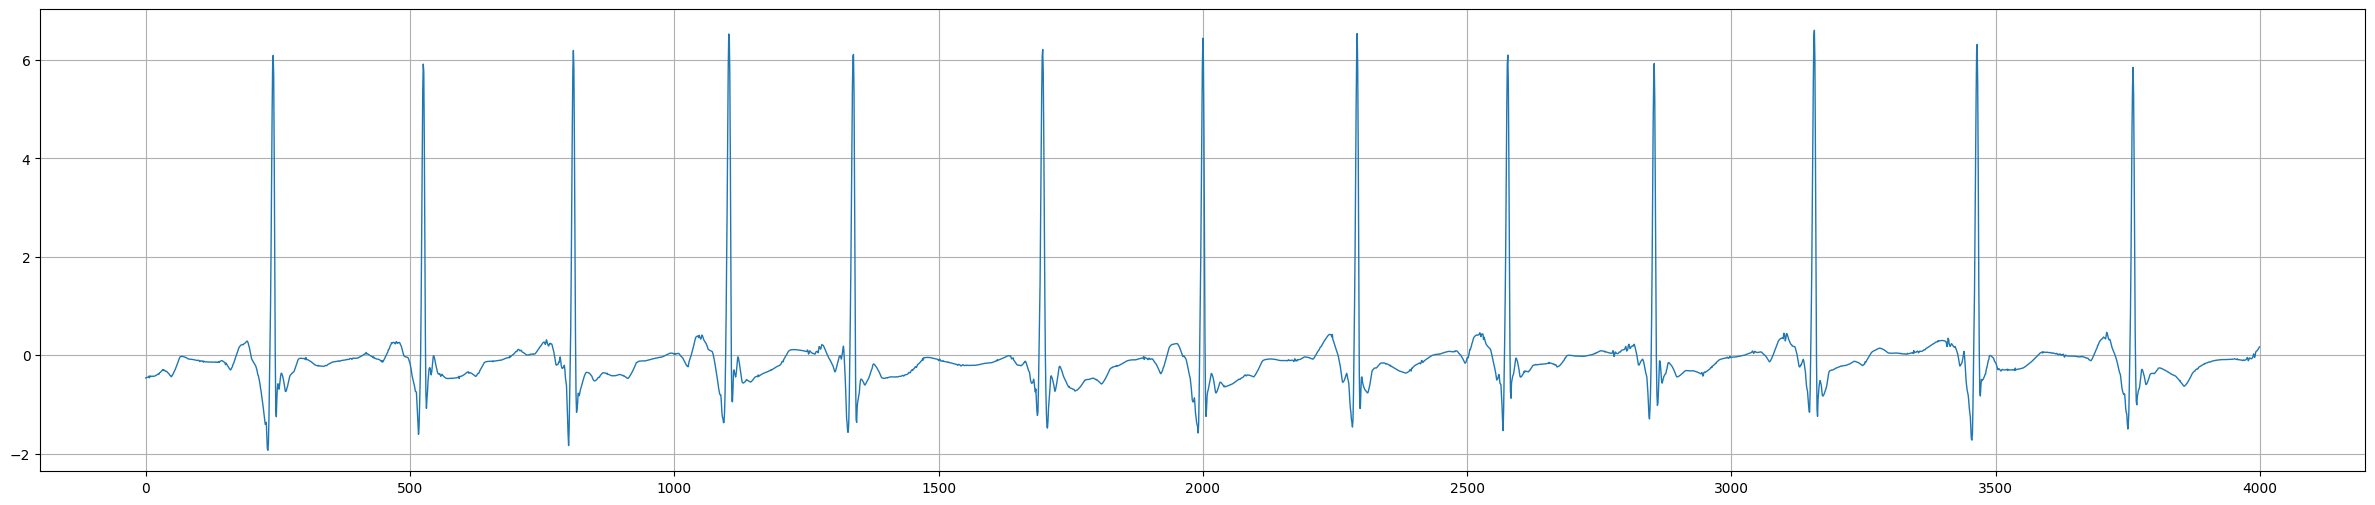

In [6]:
plt.plot(X[0])
plt.show()
X_train_df = pd.DataFrame(X)

In [7]:
import numpy as np
from numpy import log

class Naakarma:
    def __init__(self, x, m=2, r=0.05, n=0.125, w=0.8):
        self.x = np.asarray(x)
        self.m = m
        self.r = r
        self.n = n
        self.w = w

    def _compute_similarity(self, m):
        N = len(self.x)
        size = N - m
        eps = 1e-10

        # Create a 2D array of windows using advanced indexing
        indices = np.arange(size)[:, None] + np.arange(m)
        X_win = self.x[indices]

        # Compute pairwise absolute differences between all windows
        D = np.abs(X_win[:, None, :] - X_win[None, :, :])

        # Compute max and min along the window elements (axis=2)
        max_d = D.max(axis=2)
        min_d = D.min(axis=2)
        nd = (max_d - min_d) / (max_d + min_d + eps)
        dx = np.exp(-(nd ** self.n) / self.r)
        similarity = dx.sum() / (size ** 2)
        
        return similarity

    def bx(self):
        return self._compute_similarity(self.m)

    def axm(self):
        return self._compute_similarity(self.m + 1)

    def eaf(self):
        a = self.axm()
        b = self.bx()
        result = -log(a) + log(b) + log(2 * self.r)
        return result


import scipy.signal as signal
def pan_tompkins(ecg_signal, fs=360):
    """ Implements the Pan-Tompkins algorithm for R-peak detection """
    
    # Step 1: Bandpass Filter (5-15 Hz for ECG QRS complex)
    bandpass = signal.firwin(33, [5, 15], pass_zero=False, fs=fs)
    filtered_ecg = signal.lfilter(bandpass, 1, ecg_signal)

    # Step 2: Differentiation (Highlights rapid changes)
    diff_ecg = np.diff(filtered_ecg)
    
    # Step 3: Squaring (Enhances peaks)
    squared_ecg = diff_ecg**2

    # Step 4: Moving Window Integration (Smoothes peaks)
    window_size = int(0.150 * fs)  # 150ms window
    mwa = np.convolve(squared_ecg, np.ones(window_size)/window_size, mode='same')

    # Step 5: Peak Detection using thresholding
    threshold = np.max(mwa) * 0.6  # Adaptive threshold
    peaks, _ = signal.find_peaks(mwa, height=threshold, distance=int(0.6 * fs))

    return peaks, mwa

In [8]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
import antropy as ant

processed_data = []

for i, r in X_train_df.iterrows():
    print("Iteration number : ", i)
    r = list(r)
    
    # Time-domain features
    r_scaled = (r - np.min(r)) / (np.max(r) - np.min(r))  # Normalizing
    peaks, _ = pan_tompkins(r_scaled)
    rr_intervals = np.diff(peaks)
    
    if len(rr_intervals) > 0:
        mean_rr = np.mean(rr_intervals)
        min_rr = np.min(rr_intervals)
        max_rr = np.max(rr_intervals)
        median_hr = np.median(60 / rr_intervals)
        logMean = np.log(mean_rr) if mean_rr > 0 else np.nan
    else:
        logMean = mean_rr = min_rr = max_rr = median_hr = np.nan
    
    # **Entropy-based features**
    sample_entropy = ant.sample_entropy(r)
    app_entropy = ant.app_entropy(r)
    perm_entropy = ant.perm_entropy(r, normalize=True)
    spectral_entropy = ant.spectral_entropy(r, sf=360, method='welch', normalize=True)
    svd_entropy = ant.svd_entropy(r, normalize=True)
    
    # **Complexity & Fractal-based features**
    higuchi_fd = ant.higuchi_fd(r)
    hjorth_mobility, hjorth_complexity = ant.hjorth_params(r)
    lz_complexity = ant.lziv_complexity(''.join(map(str, (r > np.mean(r)).astype(int))), normalize=True)
    
    # Combine all features
    features = [
        mean_rr, min_rr, max_rr, median_hr, logMean,
        sample_entropy, app_entropy, perm_entropy, spectral_entropy, svd_entropy,
        hjorth_mobility, hjorth_complexity, higuchi_fd, lz_complexity, y[i]
    ]
    
    processed_data.append(features)

# Create the final DataFrame
processedDF = pd.DataFrame(processed_data, columns=[
    'Mean_RR', 'Min_RR', 'Max_RR', 'Median_HR', 'logMeanRR',
    'Sample_Entropy', 'App_Entropy', 'Perm_Entropy', 'Spectral_Entropy', 'SVD_Entropy',
    'Hjorth_Mobility', 'Hjorth_Complexity', 'Higuchi_FD', 'Lempel_Ziv_Complexity', 'Label'
])

print(processedDF)


Iteration number :  0
Iteration number :  1
Iteration number :  2
Iteration number :  3
Iteration number :  4
Iteration number :  5
Iteration number :  6
Iteration number :  7
Iteration number :  8
Iteration number :  9
Iteration number :  10
Iteration number :  11
Iteration number :  12
Iteration number :  13
Iteration number :  14
Iteration number :  15
Iteration number :  16
Iteration number :  17
Iteration number :  18
Iteration number :  19
Iteration number :  20
Iteration number :  21
Iteration number :  22
Iteration number :  23
Iteration number :  24
Iteration number :  25
Iteration number :  26
Iteration number :  27
Iteration number :  28
Iteration number :  29
Iteration number :  30
Iteration number :  31
Iteration number :  32
Iteration number :  33
Iteration number :  34
Iteration number :  35
Iteration number :  36
Iteration number :  37
Iteration number :  38
Iteration number :  39
Iteration number :  40
Iteration number :  41
Iteration number :  42
Iteration number :  4

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights


# Use weighted loss

processedDF = processedDF.dropna()
# Splitting features and labels
newDF = processedDF.copy()
X = newDF.drop(columns=['Label']).values
y = newDF['Label'].values
y = (y != 0).astype(int)
# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert to PyTorch tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert to PyTorch tensors and move to the correct device
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)
y_tensor = torch.tensor(y, dtype=torch.long, device=device)
#y_tensor = (y_tensor != 0).long().to(device)  # Ensure it is on the correct device
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)
# Create PyTorch datasets and data loaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

class NeuralNet(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 12)  # First layer (fewer neurons)
        self.fc2 = nn.Linear(12, 16)          # Second layer
        self.fc3 = nn.Linear(16, 12) 
        self.fc4 = nn.Linear(12, num_classes) # Fourth layer (output)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)  # Dropout with 20% probability
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)  # Dropout after first layer
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)  # Dropout after second layer
        x = self.fc4(x)  # No activation, as CrossEntropyLoss expects raw scores (logits)
        return x
# Initialize the model
input_size = X.shape[1]  # Number of input features
num_classes = len(np.unique(y))  # Number of unique labels
model = NeuralNet(input_size, num_classes)
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ce_loss = nn.CrossEntropyLoss(reduction='none')

    def forward(self, inputs, targets):
        ce_loss = self.ce_loss(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

criterion = FocalLoss()


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 1000
best_accuracy = 0.0  # Track the best accuracy

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}")

    # Validation/Testing loop
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == batch_y).sum().item()
            total += batch_y.size(0)

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

    # Save the model if the current accuracy is the best
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"New best model saved with accuracy: {best_accuracy:.2f}%")

print(f"Training complete. Best Accuracy: {best_accuracy:.2f}%")


Epoch [1/1000], Loss: 0.0390
Test Accuracy: 75.82%
New best model saved with accuracy: 75.82%
Epoch [2/1000], Loss: 0.0354
Test Accuracy: 75.87%
New best model saved with accuracy: 75.87%
Epoch [3/1000], Loss: 0.0341
Test Accuracy: 75.87%
Epoch [4/1000], Loss: 0.0331
Test Accuracy: 75.87%
Epoch [5/1000], Loss: 0.0324
Test Accuracy: 75.82%
Epoch [6/1000], Loss: 0.0321
Test Accuracy: 75.71%
Epoch [7/1000], Loss: 0.0317
Test Accuracy: 76.35%
New best model saved with accuracy: 76.35%
Epoch [8/1000], Loss: 0.0311
Test Accuracy: 76.46%
New best model saved with accuracy: 76.46%
Epoch [9/1000], Loss: 0.0309
Test Accuracy: 77.21%
New best model saved with accuracy: 77.21%
Epoch [10/1000], Loss: 0.0304
Test Accuracy: 78.33%
New best model saved with accuracy: 78.33%
Epoch [11/1000], Loss: 0.0301
Test Accuracy: 78.81%
New best model saved with accuracy: 78.81%
Epoch [12/1000], Loss: 0.0298
Test Accuracy: 80.58%
New best model saved with accuracy: 80.58%
Epoch [13/1000], Loss: 0.0295
Test Accura

In [24]:

# Testing loop
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        model.to(device)
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == batch_y).sum().item()
        total += batch_y.size(0)

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


Test Accuracy: 91.81%


In [63]:
torch.save(model.state_dict(), 'myModel.pth')

In [36]:
weights = torch.load('best_model.pth')
model.load_state_dict(weights)

C:\Users\manug\AppData\Local\Temp\ipykernel_14920\3693048622.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load('best_model.pth')


<All keys matched successfully>

In [39]:
model.eval()
model.half()  # Convert model to float16

correct = 0
total = 0
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.half()  # Convert input to float16
        batch_X.to(device)
        model.to(device)
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == batch_y).sum().item()
        total += batch_y.size(0)

accuracy_fp16 = 100 * correct / total
print("Test Accuracy (float16): {:.2f}%".format(accuracy_fp16))


Test Accuracy (float16): 91.81%
